### LLaMa 3 implementation inspired by https://github.com/naklecha/llama3-from-scratch/blob/main/llama3-from-scratch.ipynb

In [1]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

In [2]:
tokenizer_path = "/Users/htkumar/llama3/Meta-Llama-3-8B/tokenizer.model"
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
# mergeable_ranks

In [3]:
vocab = {idx: bytes([idx]) for idx in range(256)}
idx = [0, 1]
text_bytes = b"".join(vocab[i] for i in idx)
text_bytes

b'\x00\x01'

In [4]:
token = list(mergeable_ranks.items())[759][0]
parts = [bytes([b]) for b in token]
parts

[b'a', b't', b'c', b'h']

In [5]:
mergeable_ranks.get(parts[0] + parts[1])

266

In [6]:
num_base_tokens = len(mergeable_ranks)

In [7]:
num_reserved_special_tokens = 256

special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [
            f"<|reserved_special_token_{i}|>"
            for i in range(5, num_reserved_special_tokens - 5)
        ]

len(special_tokens)

pat_str = r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+"  # noqa: E501


In [8]:
Path(tokenizer_path).name

'tokenizer.model'

In [9]:
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=pat_str,
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: num_base_tokens + i for i, token in enumerate(special_tokens)},
)

In [10]:
tokenizer.decode(tokenizer.encode('How are you doing'))

'How are you doing'

In [11]:
model = torch.load("/Users/htkumar/llama3/Meta-Llama-3-8B/consolidated.00.pth")

In [12]:
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [13]:
with open("/Users/htkumar/llama3/Meta-Llama-3-8B/params.json", "r") as f:
    config = json.load(f)

config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

In [14]:
dim = config['dim']
n_layers = config['n_layers']
n_heads = config['n_heads']
n_kv_heads = config['n_kv_heads']
vocab_size = config['vocab_size']
multiple_of = config['multiple_of']
ffn_dim_multiplier = config['ffn_dim_multiplier']
norm_eps = config['norm_eps']
rope_theta = torch.tensor(config['rope_theta'])


In [15]:
special_tokens_dict = {token: num_base_tokens + i for i, token in enumerate(special_tokens)}

In [16]:
bos_id = special_tokens_dict['<|begin_of_text|>']

In [17]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
tokens = [bos_id] + tokenizer.encode(prompt)
print(tokens)

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]


In [18]:
tokens = torch.tensor(tokens)

In [19]:
prompt_split = [tokenizer.decode([t]) for t in tokens]
prompt_split

['<|begin_of_text|>',
 'the',
 ' answer',
 ' to',
 ' the',
 ' ultimate',
 ' question',
 ' of',
 ' life',
 ',',
 ' the',
 ' universe',
 ',',
 ' and',
 ' everything',
 ' is',
 ' ']

In [20]:
tokens.shape

torch.Size([17])

In [21]:
model["tok_embeddings.weight"].shape

torch.Size([128256, 4096])

In [22]:
import torch.nn as nn

In [23]:
embedding_layer = nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])

tensor([[ 1.3733e-03,  5.0964e-03, -3.0365e-03,  ...,  2.2888e-03,
         -1.9531e-03, -1.7166e-05],
        [-2.7313e-03,  1.9379e-03, -1.3733e-03,  ..., -5.1498e-05,
         -1.3962e-03, -1.9836e-03],
        [ 9.5367e-04, -1.3367e-02,  4.1771e-04,  ...,  2.5940e-03,
          7.0496e-03,  4.1809e-03],
        ...,
        [ 1.8715e-23,  3.2699e-24,  1.8198e-23,  ...,  5.3767e-23,
         -2.2360e-24, -1.9852e-23],
        [ 1.9335e-23, -1.8612e-24, -1.8818e-23,  ...,  2.3368e-23,
          7.3412e-24, -3.1226e-23],
        [-7.4860e-23, -6.3693e-23,  5.5059e-24,  ...,  4.9631e-24,
         -5.4594e-23, -2.2877e-24]])

In [24]:
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([17, 4096])

In [25]:
model["layers.0.attention_norm.weight"].shape

torch.Size([4096])

In [26]:
a = torch.tensor([1, 4, 9, 15, 16])
torch.rsqrt(a)

tensor([1.0000, 0.5000, 0.3333, 0.2582, 0.2500])

In [27]:
a = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=torch.float32)
a.shape

torch.Size([2, 4])

In [28]:
a.pow(2)

tensor([[ 1.,  4.,  9., 16.],
        [25., 36., 49., 64.]])

In [29]:
mean = a.pow(2).mean(-1, keepdim=True)

In [30]:
(a * mean)

tensor([[  7.5000,  15.0000,  22.5000,  30.0000],
        [217.5000, 261.0000, 304.5000, 348.0000]])

In [31]:
weights = torch.tensor([1, 2, 3, 4])
weights.shape

torch.Size([4])

In [32]:
(a * mean) * weights

tensor([[   7.5000,   30.0000,   67.5000,  120.0000],
        [ 217.5000,  522.0000,  913.5000, 1392.0000]])

In [33]:

weights.shape

torch.Size([4])

In [34]:
def rms_norm(tensor, norm_weights):
    normalized_tensor = tensor * (torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps))
    return normalized_tensor * norm_weights

In [35]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
token_embeddings.shape

torch.Size([17, 4096])

In [36]:
model["layers.0.attention.wq.weight"].shape, model["layers.0.attention.wk.weight"].shape, model["layers.0.attention.wv.weight"].shape, model["layers.0.attention.wo.weight"].shape

(torch.Size([4096, 4096]),
 torch.Size([1024, 4096]),
 torch.Size([1024, 4096]),
 torch.Size([4096, 4096]))

In [37]:
n_heads, n_kv_heads

(32, 8)

In [38]:
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, -1)
q_layer0.shape

torch.Size([32, 128, 4096])

In [39]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

In [40]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape # 17 tokens, each token has a query of dim 128

torch.Size([17, 128])

In [41]:
q_per_token[0, :10]

tensor([-0.0757, -0.1094,  0.2734, -0.2119,  0.2656, -0.3750, -0.1484,  0.3008,
         0.3965, -0.2832], dtype=torch.bfloat16, grad_fn=<SliceBackward0>)

In [42]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs[0, :5, :]

tensor([[-0.0757, -0.1094],
        [ 0.2734, -0.2119],
        [ 0.2656, -0.3750],
        [-0.1484,  0.3008],
        [ 0.3965, -0.2832]], grad_fn=<SliceBackward0>)

In [43]:
torch.tensor(range(64))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [44]:
zero_to_one_split_64_parts = torch.arange(64) / 64
zero_to_one_split_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [45]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

In [46]:
freqs_for_each_token = torch.outer(torch.arange(17), freqs)
freqs_for_each_token

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 8.1462e-01, 6.6360e-01,  ..., 3.6997e-06, 3.0139e-06,
         2.4551e-06],
        [2.0000e+00, 1.6292e+00, 1.3272e+00,  ..., 7.3994e-06, 6.0277e-06,
         4.9103e-06],
        ...,
        [1.4000e+01, 1.1405e+01, 9.2904e+00,  ..., 5.1796e-05, 4.2194e-05,
         3.4372e-05],
        [1.5000e+01, 1.2219e+01, 9.9540e+00,  ..., 5.5496e-05, 4.5208e-05,
         3.6827e-05],
        [1.6000e+01, 1.3034e+01, 1.0618e+01,  ..., 5.9196e-05, 4.8222e-05,
         3.9282e-05]])

In [47]:
torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)

tensor([[ 1.0000+0.0000e+00j,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
          ...,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
          1.0000+0.0000e+00j],
        [ 0.5403+8.4147e-01j,  0.6861+7.2746e-01j,  0.7878+6.1596e-01j,
          ...,  1.0000+3.6997e-06j,  1.0000+3.0139e-06j,
          1.0000+2.4551e-06j],
        [-0.4161+9.0930e-01j, -0.0584+9.9829e-01j,  0.2412+9.7048e-01j,
          ...,  1.0000+7.3994e-06j,  1.0000+6.0277e-06j,
          1.0000+4.9103e-06j],
        ...,
        [ 0.1367+9.9061e-01j,  0.3978-9.1749e-01j, -0.9910+1.3396e-01j,
          ...,  1.0000+5.1796e-05j,  1.0000+4.2194e-05j,
          1.0000+3.4372e-05j],
        [-0.7597+6.5029e-01j,  0.9404-3.4018e-01j, -0.8632-5.0488e-01j,
          ...,  1.0000+5.5496e-05j,  1.0000+4.5208e-05j,
          1.0000+3.6827e-05j],
        [-0.9577-2.8790e-01j,  0.8927+4.5066e-01j, -0.3690-9.2942e-01j,
          ...,  1.0000+5.9196e-05j,  1.0000+4.8222e-05j,
          1.0000+3.9282e-05j]])

In [48]:
import numpy as np
angle = torch.tensor([np.pi / 2, 5 * np.pi / 4], dtype=torch.float64)
angle

tensor([1.5708, 3.9270], dtype=torch.float64)

In [49]:
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

torch.Size([17, 64])

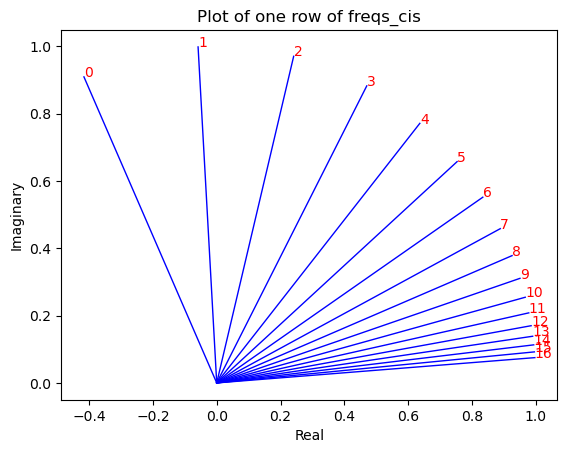

In [50]:
value = freqs_cis[2]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1)
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')

plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

In [51]:
value

tensor([-0.4161+9.0930e-01j, -0.0584+9.9829e-01j,  0.2412+9.7048e-01j,
         0.4703+8.8250e-01j,  0.6366+7.7121e-01j,  0.7535+6.5747e-01j,
         0.8340+5.5175e-01j,  0.8888+4.5832e-01j,  0.9257+3.7819e-01j,
         0.9505+3.1072e-01j,  0.9671+2.5454e-01j,  0.9781+2.0813e-01j,
         0.9855+1.6997e-01j,  0.9903+1.3868e-01j,  0.9936+1.1310e-01j,
         0.9957+9.2197e-02j,  0.9972+7.5141e-02j,  0.9981+6.1231e-02j,
         0.9988+4.9890e-02j,  0.9992+4.0647e-02j,  0.9995+3.3115e-02j,
         0.9996+2.6978e-02j,  0.9998+2.1977e-02j,  0.9998+1.7904e-02j,
         0.9999+1.4585e-02j,  0.9999+1.1881e-02j,  1.0000+9.6787e-03j,
         1.0000+7.8845e-03j,  1.0000+6.4228e-03j,  1.0000+5.2322e-03j,
         1.0000+4.2622e-03j,  1.0000+3.4721e-03j,  1.0000+2.8284e-03j,
         1.0000+2.3041e-03j,  1.0000+1.8769e-03j,  1.0000+1.5290e-03j,
         1.0000+1.2455e-03j,  1.0000+1.0146e-03j,  1.0000+8.2655e-04j,
         1.0000+6.7332e-04j,  1.0000+5.4850e-04j,  1.0000+4.4681e-04j,
      

In [52]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [53]:
q_per_token_split_into_pairs[0, :10]

tensor([[-0.0757, -0.1094],
        [ 0.2734, -0.2119],
        [ 0.2656, -0.3750],
        [-0.1484,  0.3008],
        [ 0.3965, -0.2832],
        [-0.4258,  0.3301],
        [-0.1523, -0.3008],
        [ 0.0144, -0.2119],
        [ 0.9453,  0.2676],
        [ 0.0635, -0.3125]], grad_fn=<SliceBackward0>)

In [54]:
q_per_token_as_complex_numbers[1, :10]

tensor([ 0.1660-0.2773j,  0.3652-0.5156j,  0.3809-0.8008j, -1.3359+0.3750j,
         0.6094-1.0469j, -0.2129+0.7539j, -0.4062-1.1875j, -0.1904-0.6094j,
         0.6172+0.0339j,  0.9375+0.0967j], grad_fn=<SliceBackward0>)

In [55]:
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated[1, :10]

tensor([ 0.3231-0.0102j,  0.6257-0.0881j,  0.7933-0.3962j, -1.3384-0.3660j,
         0.9975-0.6872j, -0.4640+0.6312j, -0.0469-1.2542j, -0.0414-0.6371j,
         0.5991+0.1522j,  0.9106+0.2430j], grad_fn=<SliceBackward0>)

In [56]:
q_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [57]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [58]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([17, 128])

In [59]:
n_kv_heads

8

In [60]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0.shape

torch.Size([1024, 4096])

In [61]:
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
k_layer0.shape

torch.Size([8, 128, 4096])

In [62]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [63]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([17, 128])

In [64]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [65]:
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [66]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [67]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape

torch.Size([17, 128])

In [68]:
q_per_token_rotated.shape

torch.Size([17, 128])

In [69]:
tokens.shape

torch.Size([17])

In [70]:
qk_per_token = torch.matmul(q_per_token, k_per_token.T) / (head_dim ** 0.5)
qk_per_token.shape

torch.Size([17, 17])

In [71]:
# qk_per_token
len(prompt_split)

17

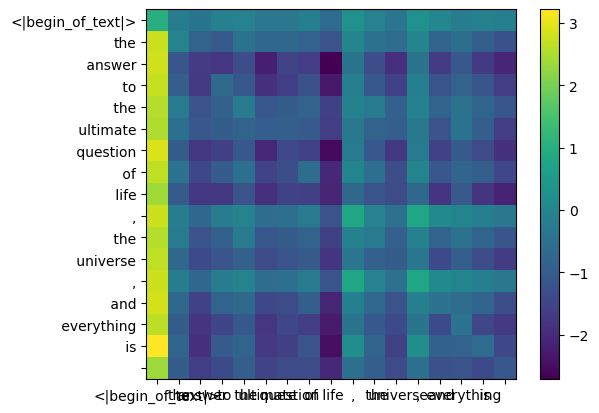

In [72]:
def display_qk_headmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split)))
    ax.set_yticks(range(len(prompt_split)))
    ax.set_xticklabels(prompt_split)
    ax.set_yticklabels(prompt_split)
    ax.figure.colorbar(im, ax=ax)

display_qk_headmap(qk_per_token)

In [73]:
mask = torch.triu(torch.ones(len(tokens), len(tokens)), diagonal=1).bool()
# mask

In [74]:
qk_per_token.masked_fill_(mask, -torch.inf);

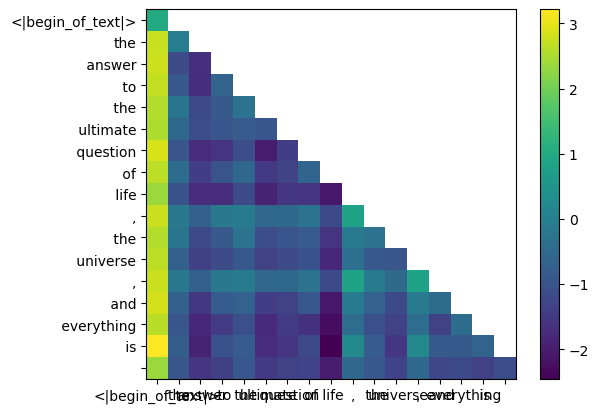

In [75]:
display_qk_headmap(qk_per_token)

In [76]:
qk_per_token_softmax = torch.nn.functional.softmax(qk_per_token, dim=-1)
type(qk_per_token_softmax)
qk_per_token_softmax.shape

torch.Size([17, 17])

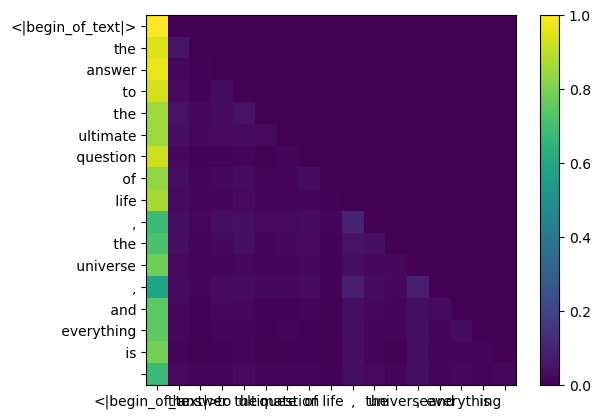

In [77]:
display_qk_headmap(qk_per_token_softmax)

In [78]:
qk_per_token_softmax[16]

tensor([0.6719, 0.0242, 0.0128, 0.0160, 0.0256, 0.0142, 0.0168, 0.0170, 0.0084,
        0.0369, 0.0256, 0.0170, 0.0369, 0.0186, 0.0195, 0.0162, 0.0212],
       dtype=torch.bfloat16, grad_fn=<SelectBackward0>)

In [79]:
qk_per_token_softmax.shape

torch.Size([17, 17])

In [80]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape

torch.Size([8, 128, 4096])

In [81]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 4096])

In [82]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([17, 128])

In [83]:
qkv_attention = torch.matmul(qk_per_token_softmax, v_per_token)
qkv_attention.shape

torch.Size([17, 128])

#### Multi-head attention

In [84]:
n_heads

32

In [85]:
q_layer0.shape, k_layer0.shape

(torch.Size([32, 128, 4096]), torch.Size([8, 128, 4096]))

In [86]:
freqs_cis.shape

torch.Size([17, 64])

In [87]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head // 4]
    v_layer0_head = v_layer0[head // 4]

    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T) # [17, 128]
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    # Now add ROPE to query and key
    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2) # [17, 64, 2]
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs) # [17, 64]
    q_per_token_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)]) # [17, 64, 2]
    q_per_token_rotated = q_per_token_rotated.view(q_per_token.shape) # [17, 128]

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2) # [17, 64, 2]
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs) # [17, 64]
    k_per_token_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)]) # [17, 64, 2]
    k_per_token_rotated = k_per_token_rotated.view(k_per_token.shape) # [17, 128]

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T) / (head_dim ** 0.5)
    mask = torch.triu(torch.ones(len(tokens), len(tokens)), diagonal=1).bool()
    qk_per_token.masked_fill_(mask, -torch.inf)
    qk_per_token_softmax = torch.nn.functional.softmax(qk_per_token, dim=-1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_softmax, v_per_token) # [17, 128]
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)


32

In [88]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([17, 4096])

In [89]:
w_layer0 = model['layers.0.attention.wo.weight']
w_layer0.shape

torch.Size([4096, 4096])

In [90]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([17, 4096])

In [91]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([17, 4096])

In [92]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model['layers.0.ffn_norm.weight'])
embedding_after_edit_normalized.shape

torch.Size([17, 4096])

In [93]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([17, 4096])

In [94]:
w1.shape, w2.shape, w3.shape

(torch.Size([14336, 4096]),
 torch.Size([4096, 14336]),
 torch.Size([14336, 4096]))

In [95]:
layer_0_embedding = embedding_after_edit + output_after_feedforward
layer_0_embedding.shape

torch.Size([17, 4096])

In [96]:
### The full loop in one go

In [97]:
final_embedding = token_embeddings_unnormalized

In [98]:
print(len(list(model.keys())));
'''
There are 291 keys in the model, tok_embeddings.weight is one
32 layers, each layer has 9 params (4 attention layer, 3 FF layer, one norm layer in each), last later norm and output weight matrix are other weights
'''

291


'\nThere are 291 keys in the model, tok_embeddings.weight is one\n32 layers, each layer has 9 params (4 attention layer, 3 FF layer, one norm layer in each), last later norm and output weight matrix are other weights\n'

In [99]:
32 * 9 + 3

291

In [100]:
# list(model.keys())

In [101]:
token_embeddings_unnormalized.shape

torch.Size([17, 4096])

In [111]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, -1, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, -1, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, -1, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]

    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head // 4]
        v_layer_head = v_layer[head // 4]

        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T) # [17, 128]
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)

        # Now add ROPE to query and key
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2) # [17, 64, 2]
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs) # [17, 64]
        q_per_token_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)]) # [17, 64, 2]
        q_per_token_rotated = q_per_token_rotated.view(q_per_token.shape) # [17, 128]

        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2) # [17, 64, 2]
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs) # [17, 64]
        k_per_token_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)]) # [17, 64, 2]
        k_per_token_rotated = k_per_token_rotated.view(k_per_token.shape) # [17, 128]

        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T) / (head_dim ** 0.5)
        mask = torch.triu(torch.ones(len(tokens), len(tokens)), diagonal=1).bool()
        qk_per_token.masked_fill_(mask, -torch.inf)
        qk_per_token_softmax = torch.nn.functional.softmax(qk_per_token, dim=-1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_softmax, v_per_token) # [17, 128]
        qkv_attention_store.append(qkv_attention)
    
    # Concat output from all heads and use FF layers
    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    # skip conn
    embedding_after_edit = final_embedding + embedding_delta
    
    # FF norm
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    # skip conn
    final_embedding = embedding_after_edit + output_after_feedforward
    

In [112]:
final_embedding.shape

torch.Size([17, 4096])

In [113]:
final_embedding = rms_norm(final_embedding, model['norm.weight'])
final_embedding.shape

torch.Size([17, 4096])

In [114]:
model['norm.weight'].shape

torch.Size([4096])

In [115]:
model['output.weight'].shape

torch.Size([128256, 4096])

In [116]:
final_embedding[-1].shape

torch.Size([4096])

In [117]:
logits = torch.matmul(final_embedding[-1], model['output.weight'].T)
logits.shape

torch.Size([128256])

In [118]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(2983)

In [119]:
tokenizer.decode([next_token.item()])

'42'